## Options Volatility Trading Strategy
This project aims to capitalise on differences in forecasted volatility and implied volatility of ATM (at the money) monthly-expiry options for the S&P 500 index. Monthly volatility is first estimated using an average of Close-to Close, Parkinson and Garman-Klass volatility estimators. It is then forecasted using the GARCH(1,1) model, using a max likelihood estimator to compute parameters. If the forecasted volatility is above the implied volatility, then an ATM straddle is bought, while if the forecasted volatility is below the implied volatility, an ATM straddle is sold. The positions are held for a week. Backtesting is then done, and strategy analytics and performance plots are shown.

The notebook is structured as follows:
1. [Import Data](#import-data)
2. [Helper Functions](#helper-functions)
   1. [Functions used for Signal Generation](#functions-used-for-signal-generation)
   2. [Functions used for Backtesting](#backtesting-functions)
3. [Signal Generation](#signal-generation)
4. [Backtesting](#backtesting)
5. [Strategy Analytics](#strategy-analytics)
6. [Strategy Visualisation](#strategy-visualisation)

### Import Libraries

In [1]:
# For data manipulation
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# For Visualisation
import matplotlib.pyplot as plt

# For ignoring warnings
import warnings
warnings.simplefilter("ignore")

# For data visualisation
import matplotlib.pyplot as plt

# Helper functions
import sys
sys.path.append("..")

<a id='import'></a>
## Import Data

In [2]:
# Read the data
options_data = pd.read_csv('./data/options_daily_sp500_2018_2022.csv', index_col=0)

# Change the index type to datetime
options_data.index = pd.to_datetime(options_data.index)

# Import the S&P 500 index daily data
daily_data_SP500 = pd.read_csv('./data/daily_sp500_2018_2022.csv', index_col=0)

# Change the index type to datetime
daily_data_SP500.index = pd.to_datetime(daily_data_SP500.index)

# Merge both dataframes to include the information of underlying data into options data
options_data = options_data.merge(daily_data_SP500[[
    'Open', 'High', 'Low', 'Close']], left_index=True, right_index=True, how='left').dropna()

option_chain = pd.read_csv('./data/option_chain_spx.csv', index_col=0)
option_chain.index = pd.to_datetime(option_chain.index)

## Helper Functions <a name="helper-functions"></a>
This section of the notebook includes helper functions that will be used in later parts of the notebook.
### Functions used for Signal Generation

In [3]:
# Find the likelihood for given parameters
def garch_likelihood(params, returns, vol):
    gamma = params[0]
    alpha = params[1]
    beta = params[2]
    log_likelihood = 0
    for i in range(1, len(returns)):
        variance = gamma * vol[0] + alpha * returns[i-1]**2 + beta * vol[i-1]
        log_likelihood -= np.log(variance) + returns[i]**2 / variance
    return -log_likelihood


# Define the GARCH(1,1) model's initial parameters and their bounds
initial_params = [0.1, 0.1, 0.1]
params_bounds = [(0,1), (0,1), (0,1)]

# Find max likelihood parameters
def estimate_params(args):
    result = minimize(garch_likelihood, initial_params, args = args, bounds = params_bounds, method = 'SLSQP')
    return result.x

# Function to forecast volatility
def forecast_volatility(params, returns, vol):
    gamma = params[0]
    alpha = params[1]
    beta = params[2]
    result = gamma * vol[0] + alpha * returns[-1]**2 + beta * vol[-1]
    return result

### Functions used for Backtesting

In [4]:
# Function to calculate the premium of a straddle
def premium(type, data):
    if type == 'CE':
        return data['C_LAST']
    return data['P_LAST']

# Function to setup a straddle
def new_straddle(data):
    straddle = pd.DataFrame()
    straddle['option_type'] = ['CE', 'PE']
    straddle['strike'] = data.STRIKE
    straddle['premium'] = straddle.apply(lambda x: premium(x['option_type'], data), axis=1)
    return straddle

# Function to enter a trade
def trade(direction, entry_price, entry_time, exit_price, exit_time):
    pnl = (exit_price - entry_price) * direction
    position = 'Long' if direction == 1 else 'Short'
    trades = pd.DataFrame(columns = ['Position', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'PnL'])
    return trades.append({
        'Position': position,
        'Entry Time' : entry_time,
        'Entry Price' : entry_price,
        'Exit Time' : exit_time, 
        'Exit Price': exit_price, 
        'PnL' : pnl
    }, ignore_index=True)



## Signal Generation

In [5]:
# Run the strategy for the last year of data and generate a signal every 5 days
last_year = options_data[252*4:]
last_signal_target = 5
last_signal = last_signal_target
# Create a column to store signals
options_data['signal'] = 0
options_data['forecasted_volatility'] = np.nan
# Dictionary used to specify which aggregate function to apply to columns when changing from daily data to monthly data
columns_functions ={
    'Open': 'first',
    'Close': 'last',
    'High': 'max',
    'Low': 'min'
}

for date in last_year.index:
    if last_signal >= last_signal_target:
        # We will be using data from the last 4 years to forecast volatility
        data = options_data[:date][-252*4:]
        data.index = pd.to_datetime(data.index)
        # Convert into monthly data to calculate monthly volatility
        monthly_data = data.resample('M').agg(columns_functions).dropna()
        # Estimate the volatility using the three different estimators
        
        # Close to Close volatility
        monthly_returns = np.log(monthly_data['Close']/monthly_data['Close'].shift(1)).dropna()
        monthly_data['c_to_c'] = monthly_returns.std()
        
        # Parkinson
        high_low = np.log(monthly_data['High']/monthly_data['Low'])
        monthly_data['parkinson'] = np.sqrt((1/(4*np.log(2)))*(high_low**2).sum())
        
        # Garman-Klass
        monthly_data['garman_klass'] = np.sqrt((0.5)*((high_low**2).sum()) - (((2 * np.log(2))-1)*(monthly_returns**2).sum()))

        # Average Volatility        
        avg_vol = (monthly_data['garman_klass'] + monthly_data['parkinson'] + monthly_data['c_to_c']) / 3

        # Estimate GARCH(1,1) model parametrs using max likelihood estimation and forecast volatility
        parameters = estimate_params((monthly_returns, avg_vol))
        forecasted_volatility = forecast_volatility(parameters, monthly_returns, avg_vol)
        options_data.at[date, 'forecasted_volatility'] = forecasted_volatility * 100

        # Compare with implied volatility
        if forecasted_volatility*100 > options_data.loc[date].C_IV and forecasted_volatility*100 > options_data.loc[date].P_IV:
            options_data.loc[date:date+pd.DateOffset(days = 4), 'signal'] = 1
            last_signal = 0
        elif forecasted_volatility*100 < options_data.loc[date].C_IV and forecasted_volatility*100 < options_data.loc[date].P_IV:
            options_data.loc[date:date+pd.DateOffset(days = 4), 'signal'] = -1
            last_signal = 0
    else:
        last_signal += 1

## Backtest


In [6]:
current_position = 0
backtest_data = options_data["signal"].copy()[242*4:]
prev_signal = np.nan
trade_book = pd.DataFrame(columns = ['Position', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'PnL'])

for date, signal in backtest_data.items():
    # Enter trade
    if current_position == 0 and signal !=0:
        straddle = new_straddle(options_data.loc[date])
        strike = options_data.loc[date].STRIKE
        entry_time = date
        entry_price = round((straddle['premium']).sum(), 2)
        current_position = signal
    # Exit trade
    elif current_position != 0 and signal == 0:
        exit_time = date
        exit = option_chain.loc[date.strftime('%Y-%m-%d')]
        exit = exit[exit.Strike == strike]
        exit_price = exit['C_last'].at[exit.index[0]] + exit['P_last'].at[exit.index[0]]
        trade_book = pd.concat([trade_book, trade(current_position, entry_price, entry_time, exit_price, exit_time)])
        trade_book = trade_book.reset_index(drop = True)
        current_position = 0


<a id='analytics'></a>
## Strategy Analytics

In [7]:
trade_book['Cumulative PnL'] = trade_book['PnL'].cumsum()
trade_book['Trade Returns (%)'] = round(trade_book['PnL'] / trade_book['Entry Price'], 2) * 100

analytics = pd.DataFrame(index=['Strategy'])
# Calculate total PnL
analytics['Total PnL'] = trade_book.PnL.sum()

# Number of total trades
analytics['Total Trades'] = len(trade_book)


# Profitable trades
analytics['Positive Trades'] = len(trade_book.loc[trade_book.PnL > 0])

# Loss-making trades
analytics['Negative Trades'] = len(trade_book.loc[trade_book.PnL <= 0])

# Per trade profit/loss of winning trades
analytics['Per Trade PnL of Winners'] = round(trade_book.loc[trade_book.PnL > 0].PnL.mean(), 2)

# Per trade profit/loss of losing trades
analytics['Per Trade PnL of Losers'] = round(abs(trade_book.loc[trade_book.PnL <= 0].PnL.mean()), 2)

# Profit factor
winners = trade_book.loc[trade_book.PnL > 0]
made = winners.PnL.sum()
losers = trade_book.loc[trade_book.PnL<= 0]
lost = losers.PnL.sum()
analytics['Profit Factor'] = round(abs(made/lost), 2)

# Average Returns
analytics['Average Returns (%)'] = trade_book['Trade Returns (%)'].mean()
analytics

,Total PnL,Total Trades,Positive Trades,Negative Trades,Per Trade PnL of Winners,Per Trade PnL of Losers,Profit Factor,Average Returns (%)
Strategy,438.62,18,12,6,52.07,31.03,3.36,23.0


## Strategy Visualisation

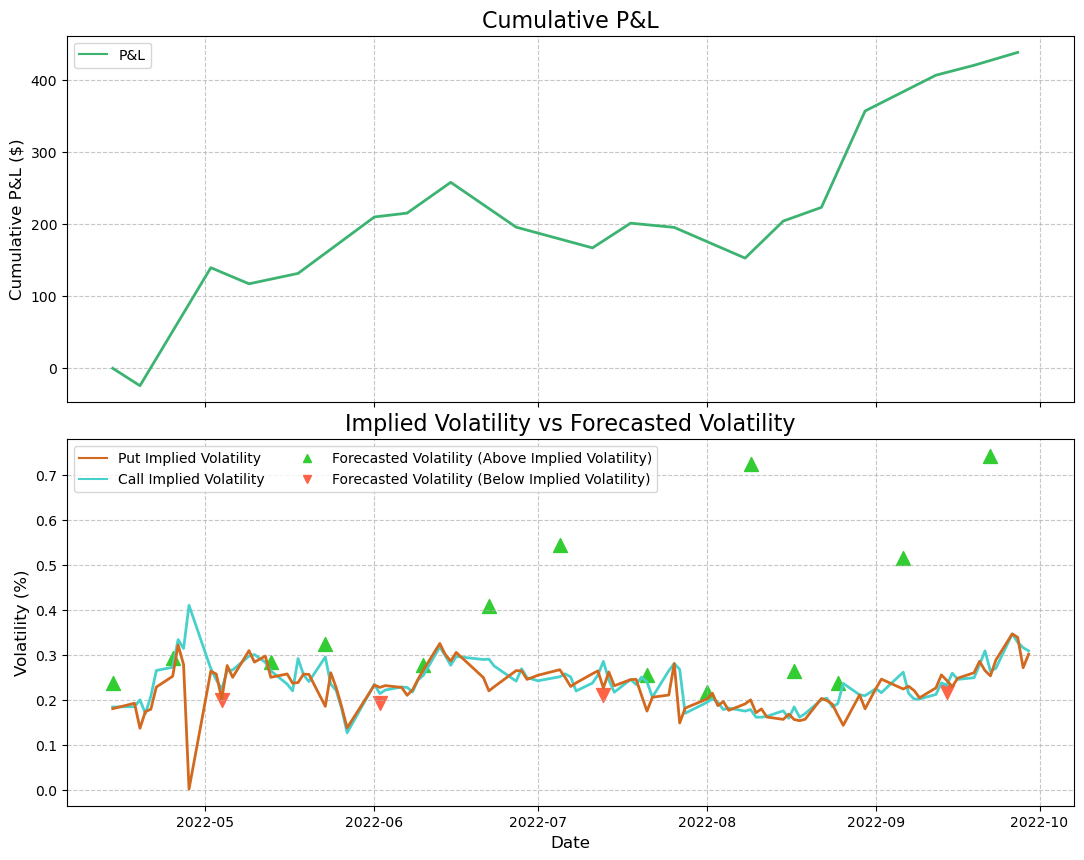

In [8]:
# Prepare data
signals = trade_book[['Position', 'Entry Time']].copy()
signals['price'] = 0
signals_long = signals[signals['Position'] == 'Long']
signals_short = signals[signals['Position'] == 'Short']
signals_short = signals_short.merge(options_data[252*4:]['forecasted_volatility'], how='left', left_on='Entry Time', right_on=' [QUOTE_DATE]')
signals_long = signals_long.merge(options_data[252*4:]['forecasted_volatility'], how='left', left_on='Entry Time', right_on=' [QUOTE_DATE]')


# Add point (0, 0)
start_position = {
    'Position': 'No Position',
    'Entry Time': pd.to_datetime('2022-04-14'),
    'Entry Price': 0,
    'Exit Time': pd.to_datetime('2022-04-14'),
    'Exit Price': 0,
    'PnL': 0,
    'Cumulative PnL': 0
}
start_position = pd.DataFrame([start_position])
trade_book = pd.concat([start_position, trade_book], ignore_index=True)
# Create a figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 10), sharex=True)

# Plot the main data on the top axis (ax1)
ax1.plot(trade_book['Exit Time'], trade_book['Cumulative PnL'], color='mediumseagreen', linestyle='-', linewidth=2)
ax1.set_ylabel('Cumulative P&L ($)', fontsize=12)
ax1.set_title('Cumulative P&L', fontsize=16)

# Add grid lines to the top plot
ax1.grid(True, linestyle='--', alpha=0.7)

# Add a legend for the top plot
ax1.legend(loc='upper left', prop={'size': 10}, ncol=2, frameon=True,
               handles=[plt.Line2D([], [], color='mediumseagreen', label='P&L')])


# Plot additional data on the bottom axis (ax2)
ax2.plot(options_data[252*4:].index, options_data[252*4:].C_IV, color='mediumturquoise', linestyle='-', linewidth=2, label='Call Implied Volatility')
ax2.plot(options_data[252*4:].index, options_data[252*4:].P_IV, color='chocolate', linestyle='-', linewidth=2, label='Put Implied Volatility')
ax2.scatter(signals_long['Entry Time'], signals_long['forecasted_volatility'], color='limegreen', marker='^', alpha=1, s=100, label='Buy Signal')
ax2.scatter(signals_short['Entry Time'], signals_short['forecasted_volatility'], color='tomato', marker='v', alpha=1, s=100, label='Sell Signal')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Volatility (%)', fontsize=12)
ax2.set_title('Implied Volatility vs Forecasted Volatility', fontsize=16)

# Add grid lines to the bottom plot
ax2.grid(True, linestyle='--', alpha=0.7)

# Add a legend for the bottom plot
ax2.legend(loc='upper left', prop={'size': 10}, ncol=2, frameon=True,
               handles=[plt.Line2D([], [], color='chocolate', label='Put Implied Volatility'),
                        plt.Line2D([], [], color='mediumturquoise', label='Call Implied Volatility'),
                        plt.Line2D([], [], color='limegreen', marker='^', linestyle='None', label='Forecasted Volatility (Above Implied Volatility)'),
                        plt.Line2D([], [], color='tomato', marker='v', linestyle='None', label='Forecasted Volatility (Below Implied Volatility)')])

# Adjust spacing between plots
plt.subplots_adjust(hspace=0.1)

# Show the plots
plt.show()